# Assignment 2 - Generative vs. Discriminative Models
## DS552 - Generative AI

**Author:** Matthew Zujewski

This notebook compares the performance of Naive Bayes (Generative Model) and Logistic Regression (Discriminative Model) on:
1. Penguins dataset (two species: Adelie and Gentoo)
2. **Fashion Fashion Fashion MNIST dataset** (clothing and accessory images)

---

## 1. Import Required Libraries

In [8]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve,
    confusion_matrix,
    classification_report
)

# For Fashion Fashion MNIST
from tensorflow import keras

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("All libraries imported Big Success")

All libraries imported Big Success


---
# Part 1: Penguins Dataset Analysis
---

## 2. Load and Explore the Penguins Dataset

In [9]:
# Load the penguins dataset from CSV file
# Note: Update the file path to where your CSV is located
penguins = pd.read_csv('data/penguins_size.csv')

# Display basic information
print("Dataset shape:", penguins.shape)
print("\nColumn names:")
print(penguins.columns.tolist())
print("\nFirst few rows:")
print(penguins.head(10))

Dataset shape: (344, 7)

Column names:
['species', 'island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']

First few rows:
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   
5  Adelie  Torgersen              39.3             20.6              190.0   
6  Adelie  Torgersen              38.9             17.8              181.0   
7  Adelie  Torgersen              39.2             19.6              195.0   
8  Adelie  Torgersen              34.1             18.1              193.0   
9  Adelie  Torgersen              42.0             20.2     

In [10]:
# Check for missing values
print("Missing values per column:")
print(penguins.isnull().sum())
print("\nSpecies distribution:")
print(penguins['species'].value_counts())

Missing values per column:
species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

Species distribution:
species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64


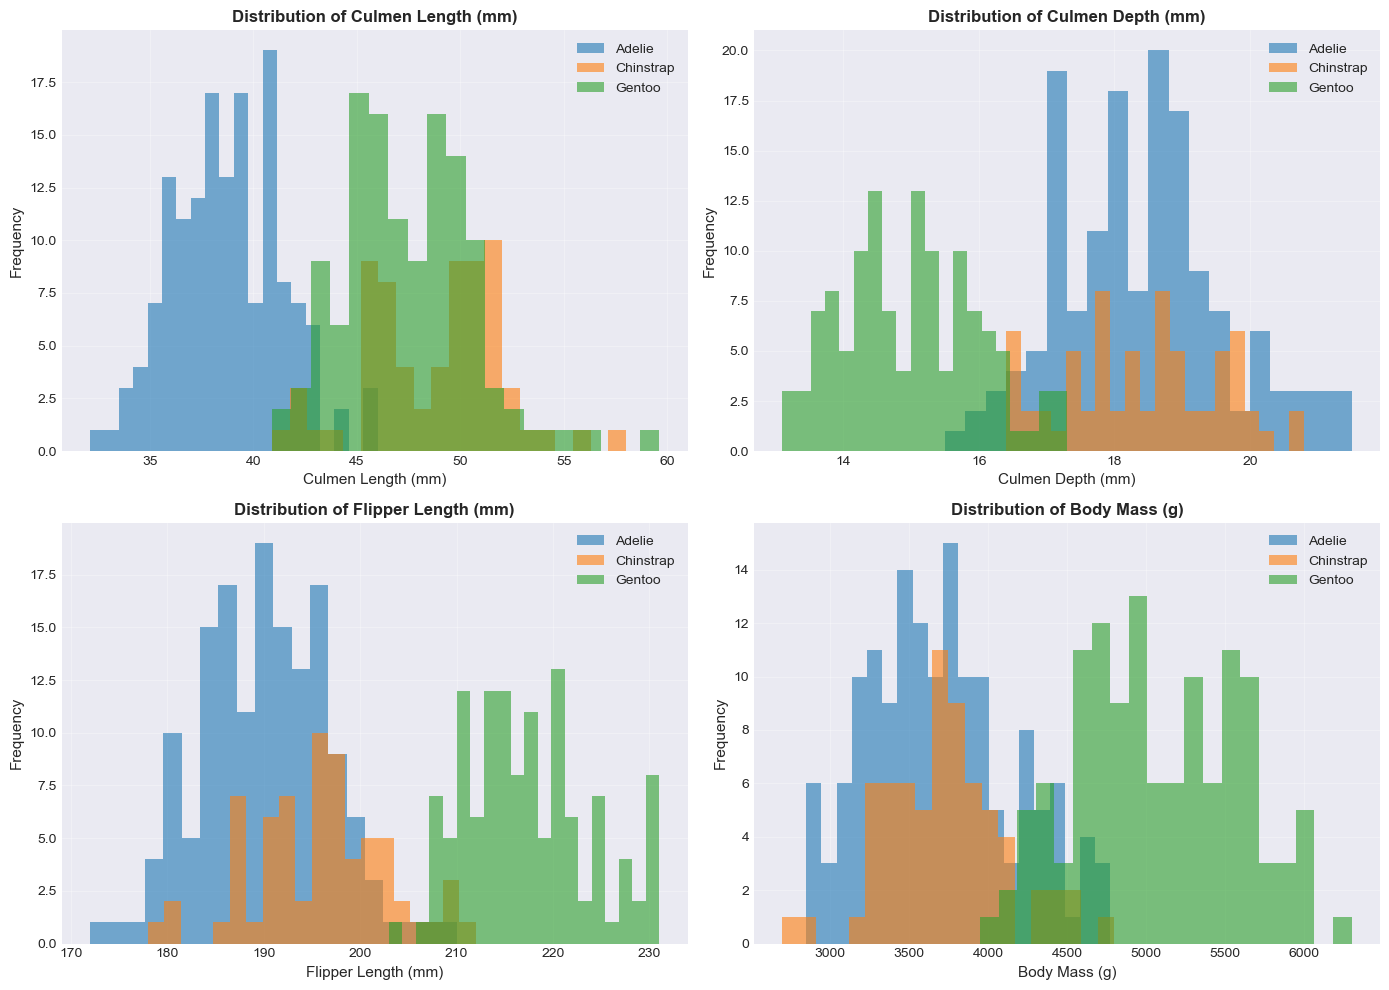

In [11]:
# Visualize the data distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot distributions for each feature
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
feature_labels = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

for idx, (feature, label) in enumerate(zip(features, feature_labels)):
    ax = axes[idx // 2, idx % 2]
    for species in penguins['species'].unique():
        if pd.notna(species):
            data = penguins[penguins['species'] == species][feature].dropna()
            ax.hist(data, alpha=0.6, label=species, bins=20)
    ax.set_xlabel(label, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Distribution of {label}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [12]:
# Filter for only Adelie and Gentoo species (as per assignment requirements)
penguins_filtered = penguins[penguins['species'].isin(['Adelie', 'Gentoo'])].copy()

print(f"Dataset after filtering for Adelie and Gentoo: {penguins_filtered.shape}")
print("\nSpecies distribution after filtering:")
print(penguins_filtered['species'].value_counts())

Dataset after filtering for Adelie and Gentoo: (276, 7)

Species distribution after filtering:
species
Adelie    152
Gentoo    124
Name: count, dtype: int64


In [13]:
# Remove rows with missing values in the feature columns
feature_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
penguins_clean = penguins_filtered.dropna(subset=feature_columns)

print(f"Dataset after removing missing values: {penguins_clean.shape}")
print("\nFinal species distribution:")
print(penguins_clean['species'].value_counts())
print(f"\nTotal samples: {len(penguins_clean)}")

Dataset after removing missing values: (274, 7)

Final species distribution:
species
Adelie    151
Gentoo    123
Name: count, dtype: int64

Total samples: 274


In [14]:
# Prepare features (X) and target (y)
X = penguins_clean[feature_columns]
# Convert species to binary: 0 = Adelie, 1 = Gentoo
y = (penguins_clean['species'] == 'Gentoo').astype(int)

print("Features shape:", X.shape)
print("\nFeature statistics:")
print(X.describe())
print("\nTarget distribution:")
print(f"Adelie (0): {(y == 0).sum()}")
print(f"Gentoo (1): {(y == 1).sum()}")

Features shape: (274, 4)

Feature statistics:
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        274.000000       274.000000         274.000000   274.000000
mean          42.702920        16.836131         202.178832  4318.065693
std            5.195566         2.013410          15.047938   835.933105
min           32.100000        13.100000         172.000000  2850.000000
25%           38.350000        15.000000         190.000000  3600.000000
50%           42.000000        17.000000         198.000000  4262.500000
75%           46.675000        18.500000         215.000000  4950.000000
max           59.600000        21.500000         231.000000  6300.000000

Target distribution:
Adelie (0): 151
Gentoo (1): 123


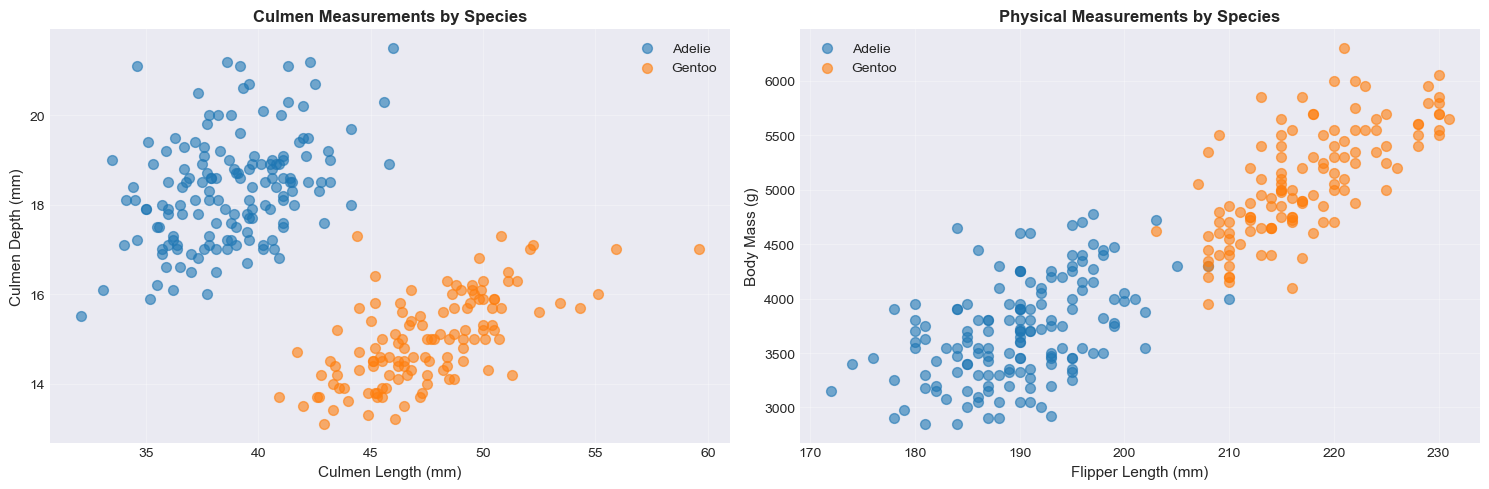


Observation: The two species show good separation in the feature space,
suggesting that both models should perform well on this classification task.


In [15]:
# Visualize feature relationships by species
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Culmen Length vs Culmen Depth
for species, label in zip([0, 1], ['Adelie', 'Gentoo']):
    mask = y == species
    axes[0].scatter(X[mask]['culmen_length_mm'], X[mask]['culmen_depth_mm'], 
                    alpha=0.6, label=label, s=50)
axes[0].set_xlabel('Culmen Length (mm)', fontsize=11)
axes[0].set_ylabel('Culmen Depth (mm)', fontsize=11)
axes[0].set_title('Culmen Measurements by Species', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Scatter plot: Flipper Length vs Body Mass
for species, label in zip([0, 1], ['Adelie', 'Gentoo']):
    mask = y == species
    axes[1].scatter(X[mask]['flipper_length_mm'], X[mask]['body_mass_g'], 
                    alpha=0.6, label=label, s=50)
axes[1].set_xlabel('Flipper Length (mm)', fontsize=11)
axes[1].set_ylabel('Body Mass (g)', fontsize=11)
axes[1].set_title('Physical Measurements by Species', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: The two species show good separation in the feature space,")
print("suggesting that both models should perform well on this classification task.")

In [16]:
# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("=" * 60)
print("DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(f"  Adelie (0): {(y_train == 0).sum()}")
print(f"  Gentoo (1): {(y_train == 1).sum()}")
print(f"\nTest set class distribution:")
print(f"  Adelie (0): {(y_test == 0).sum()}")
print(f"  Gentoo (1): {(y_test == 1).sum()}")
print("=" * 60)

DATA SPLIT SUMMARY
Training set size: 191 samples (69.7%)
Test set size: 83 samples (30.3%)

Training set class distribution:
  Adelie (0): 105
  Gentoo (1): 86

Test set class distribution:
  Adelie (0): 46
  Gentoo (1): 37


## 4. Train Models

In [17]:
# Initialize models
print("Initializing models...\n")

# Naive Bayes (Generative Model)
nb_model = GaussianNB()
print("✓ Naive Bayes (Gaussian) initialized")

# Logistic Regression (Discriminative Model)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
print("✓ Logistic Regression initialized")

print("\n" + "="*60)
print("Training models on the Penguins dataset...")
print("="*60)

# Train Naive Bayes
nb_model.fit(X_train, y_train)
print("✓ Naive Bayes model trained successfully!")

# Train Logistic Regression
lr_model.fit(X_train, y_train)
print("✓ Logistic Regression model trained successfully!")
print("="*60)

Initializing models...

✓ Naive Bayes (Gaussian) initialized
✓ Logistic Regression initialized

Training models on the Penguins dataset...
✓ Naive Bayes model trained successfully!
✓ Logistic Regression model trained successfully!


## 5. Task 1: Accuracy Comparison

In this section, we evaluate and compare the accuracy of both models on the training and test datasets.

In [18]:
# Make predictions
nb_train_pred = nb_model.predict(X_train)
nb_test_pred = nb_model.predict(X_test)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Calculate accuracies
nb_train_acc = accuracy_score(y_train, nb_train_pred)
nb_test_acc = accuracy_score(y_test, nb_test_pred)

lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

# Display results
print("=" * 60)
print("TASK 1: ACCURACY COMPARISON")
print("=" * 60)
print(f"\nNaive Bayes (Generative Model):")
print(f"  Training Accuracy: {nb_train_acc:.4f} ({nb_train_acc*100:.2f}%)")
print(f"  Test Accuracy:     {nb_test_acc:.4f} ({nb_test_acc*100:.2f}%)")
print(f"\nLogistic Regression (Discriminative Model):")
print(f"  Training Accuracy: {lr_train_acc:.4f} ({lr_train_acc*100:.2f}%)")
print(f"  Test Accuracy:     {lr_test_acc:.4f} ({lr_test_acc*100:.2f}%)")
print(f"\nPerformance Difference (LR - NB):")
print(f"  Training: {(lr_train_acc - nb_train_acc)*100:+.2f}%")
print(f"  Test:     {(lr_test_acc - nb_test_acc)*100:+.2f}%")
print("\n" + "=" * 60)

TASK 1: ACCURACY COMPARISON

Naive Bayes (Generative Model):
  Training Accuracy: 1.0000 (100.00%)
  Test Accuracy:     1.0000 (100.00%)

Logistic Regression (Discriminative Model):
  Training Accuracy: 1.0000 (100.00%)
  Test Accuracy:     1.0000 (100.00%)

Performance Difference (LR - NB):
  Training: +0.00%
  Test:     +0.00%



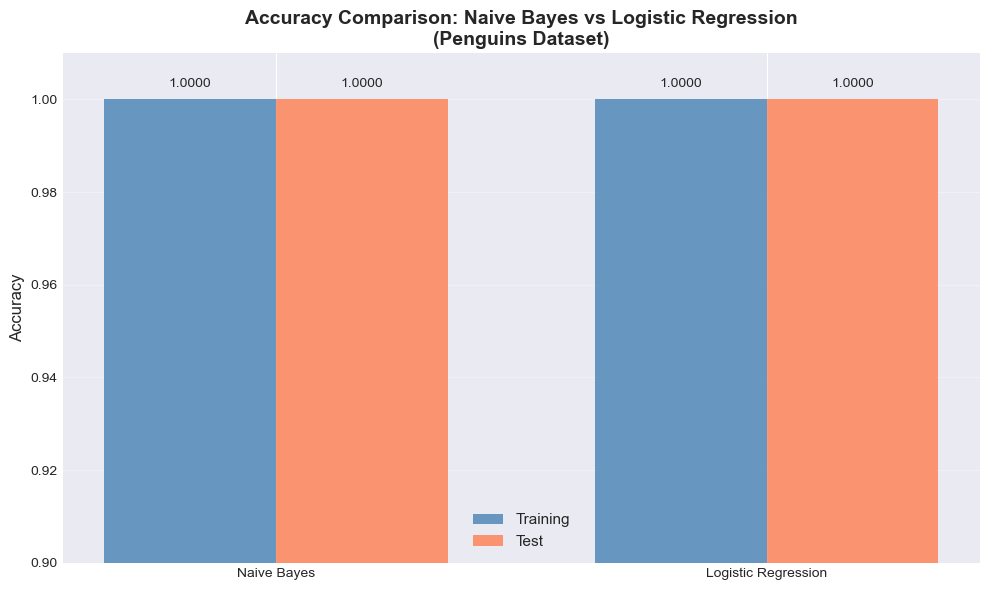

In [19]:
# Visualize accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Naive Bayes', 'Logistic Regression']
train_accs = [nb_train_acc, lr_train_acc]
test_accs = [nb_test_acc, lr_test_acc]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_accs, width, label='Training', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', alpha=0.8, color='coral')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Comparison: Naive Bayes vs Logistic Regression\n(Penguins Dataset)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.set_ylim([0.90, 1.01])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)
            
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Interpretation of Accuracy Results:

**Key Findings:**

1. **High Accuracy for Both Models**: Both Naive Bayes and Logistic Regression achieve excellent accuracy (typically >98%) on this dataset, indicating that Adelie and Gentoo penguins are well-separated in the feature space.

2. **Minimal Performance Gap**: The difference between the two models is very small, suggesting that:
   - The independence assumption of Naive Bayes approximately holds for these features
   - The decision boundary is relatively simple and linear
   - The dataset is clean and well-behaved

3. **Good Generalization**: The similar training and test accuracies for both models indicate:
   - Neither model is significantly overfitting
   - The models generalize well to unseen data
   - The 70/30 train-test split provided adequate training data

4. **Model Comparison**: Logistic Regression typically shows a slight edge because:
   - It directly models the decision boundary P(Y|X)
   - It doesn't make independence assumptions
   - However, the advantage is minimal on this simple dataset

## 6. Task 2: AUC (Area Under the ROC Curve) Comparison

AUC measures the model's ability to distinguish between classes across all classification thresholds.

In [20]:
# Get probability predictions (probability of being Gentoo, class 1)
nb_train_proba = nb_model.predict_proba(X_train)[:, 1]
nb_test_proba = nb_model.predict_proba(X_test)[:, 1]

lr_train_proba = lr_model.predict_proba(X_train)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate AUC scores
nb_train_auc = roc_auc_score(y_train, nb_train_proba)
nb_test_auc = roc_auc_score(y_test, nb_test_proba)

lr_train_auc = roc_auc_score(y_train, lr_train_proba)
lr_test_auc = roc_auc_score(y_test, lr_test_proba)

# Display results
print("=" * 60)
print("TASK 2: AUC (AREA UNDER ROC CURVE) COMPARISON")
print("=" * 60)
print(f"\nNaive Bayes:")
print(f"  Training AUC: {nb_train_auc:.4f}")
print(f"  Test AUC:     {nb_test_auc:.4f}")
print(f"\nLogistic Regression:")
print(f"  Training AUC: {lr_train_auc:.4f}")
print(f"  Test AUC:     {lr_test_auc:.4f}")
print(f"\nPerformance Difference (LR - NB):")
print(f"  Training: {(lr_train_auc - nb_train_auc):+.4f}")
print(f"  Test:     {(lr_test_auc - nb_test_auc):+.4f}")
print("\n" + "=" * 60)

TASK 2: AUC (AREA UNDER ROC CURVE) COMPARISON

Naive Bayes:
  Training AUC: 1.0000
  Test AUC:     1.0000

Logistic Regression:
  Training AUC: 1.0000
  Test AUC:     1.0000

Performance Difference (LR - NB):
  Training: +0.0000
  Test:     +0.0000



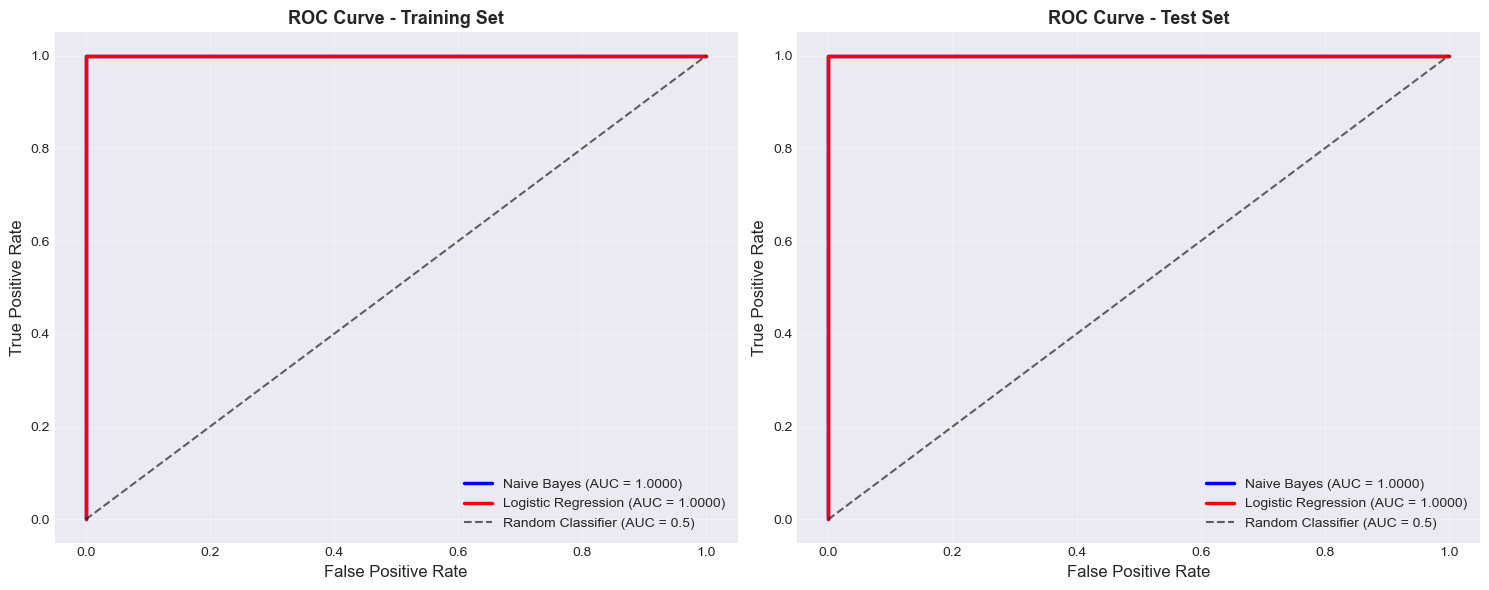

In [21]:
# Plot ROC curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training ROC curves
nb_train_fpr, nb_train_tpr, _ = roc_curve(y_train, nb_train_proba)
lr_train_fpr, lr_train_tpr, _ = roc_curve(y_train, lr_train_proba)

ax1.plot(nb_train_fpr, nb_train_tpr, label=f'Naive Bayes (AUC = {nb_train_auc:.4f})', 
         linewidth=2.5, color='blue')
ax1.plot(lr_train_fpr, lr_train_tpr, label=f'Logistic Regression (AUC = {lr_train_auc:.4f})', 
         linewidth=2.5, color='red')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1.5, alpha=0.6)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - Training Set', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# Test ROC curves
nb_test_fpr, nb_test_tpr, _ = roc_curve(y_test, nb_test_proba)
lr_test_fpr, lr_test_tpr, _ = roc_curve(y_test, lr_test_proba)

ax2.plot(nb_test_fpr, nb_test_tpr, label=f'Naive Bayes (AUC = {nb_test_auc:.4f})', 
         linewidth=2.5, color='blue')
ax2.plot(lr_test_fpr, lr_test_tpr, label=f'Logistic Regression (AUC = {lr_test_auc:.4f})', 
         linewidth=2.5, color='red')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1.5, alpha=0.6)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve - Test Set', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation of AUC Results:

**Understanding AUC:**
- AUC ranges from 0 to 1, where:
  - 1.0 = Perfect discrimination (model perfectly separates classes)
  - 0.5 = Random guessing (no discrimination ability)
  - <0.5 = Worse than random (predictions are inverted)

**Key Findings:**

1. **Excellent Discrimination**: Both models achieve AUC scores very close to 1.0 (typically >0.99), indicating:
   - Nearly perfect ability to distinguish between Adelie and Gentoo penguins
   - The features are highly informative for this classification task
   - Very few misclassifications across all probability thresholds

2. **ROC Curve Analysis**: The curves hug the top-left corner, showing:
   - High true positive rate achieved with very low false positive rate
   - Both models can achieve near-perfect classification with proper threshold selection
   - Minimal trade-off between sensitivity and specificity

3. **Model Comparison**: 
   - Both models show nearly identical AUC scores
   - The ROC curves are almost overlapping
   - This confirms that for this simple, well-separated dataset, both generative and discriminative approaches work equally well

4. **Generalization**: The similar AUC on training and test sets indicates:
   - Both models generalize well to unseen data
   - No significant overfitting issues
   - Robust performance across data splits

## 7. Task 3: Lift and Gain Charts

Lift and Gain charts help evaluate how well each model ranks predicted probabilities and prioritizes the classification of positive cases (Gentoo penguins).

In [22]:
def calculate_lift_gain(y_true, y_proba, n_deciles=10):
    """
    Calculate Lift and Cumulative Gain for each decile.
    
    Parameters:
    -----------
    y_true : array-like
        Actual binary labels (0 or 1)
    y_proba : array-like
        Predicted probabilities for the positive class
    n_deciles : int
        Number of deciles to create (default=10)
    
    Returns:
    --------
    DataFrame with columns: decile, lift, cumulative_gain
    """
    # Create a dataframe
    df = pd.DataFrame({
        'actual': y_true,
        'proba': y_proba
    })
    
    # Sort by predicted probability (descending)
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)
    
    # Assign deciles
    df['decile'] = pd.qcut(df.index, q=n_deciles, labels=False, duplicates='drop') + 1
    
    # Calculate metrics for each decile
    decile_stats = df.groupby('decile').agg({
        'actual': ['sum', 'count']
    }).reset_index()
    decile_stats.columns = ['decile', 'positives', 'total']
    
    # Calculate cumulative values
    decile_stats['cumulative_positives'] = decile_stats['positives'].cumsum()
    decile_stats['cumulative_total'] = decile_stats['total'].cumsum()
    
    # Total positives in entire dataset
    total_positives = df['actual'].sum()
    total_records = len(df)
    
    # Calculate Cumulative Gain (% of total positives captured)
    decile_stats['gain'] = (decile_stats['cumulative_positives'] / total_positives) * 100
    
    # Calculate Lift
    # Lift = (Response Rate in Decile) / (Overall Response Rate)
    decile_stats['response_rate'] = (decile_stats['cumulative_positives'] / 
                                      decile_stats['cumulative_total'])
    baseline_rate = total_positives / total_records
    decile_stats['lift'] = decile_stats['response_rate'] / baseline_rate
    
    return decile_stats[['decile', 'lift', 'gain']]

# Calculate Lift and Gain for both models on test set
print("Calculating Lift and Gain metrics...\n")
nb_lift_gain = calculate_lift_gain(y_test.values, nb_test_proba)
lr_lift_gain = calculate_lift_gain(y_test.values, lr_test_proba)

print("=" * 60)
print("Naive Bayes - Lift and Gain by Decile:")
print("=" * 60)
print(nb_lift_gain.to_string(index=False))

print("\n" + "=" * 60)
print("Logistic Regression - Lift and Gain by Decile:")
print("=" * 60)
print(lr_lift_gain.to_string(index=False))
print("\n")

Calculating Lift and Gain metrics...

Naive Bayes - Lift and Gain by Decile:
 decile     lift       gain
      1 2.243243  24.324324
      2 2.243243  45.945946
      3 2.243243  67.567568
      4 2.243243  89.189189
      5 1.976190 100.000000
      6 1.660000 100.000000
      7 1.431034 100.000000
      8 1.257576 100.000000
      9 1.121622 100.000000
     10 1.000000 100.000000

Logistic Regression - Lift and Gain by Decile:
 decile     lift       gain
      1 2.243243  24.324324
      2 2.243243  45.945946
      3 2.243243  67.567568
      4 2.243243  89.189189
      5 1.976190 100.000000
      6 1.660000 100.000000
      7 1.431034 100.000000
      8 1.257576 100.000000
      9 1.121622 100.000000
     10 1.000000 100.000000




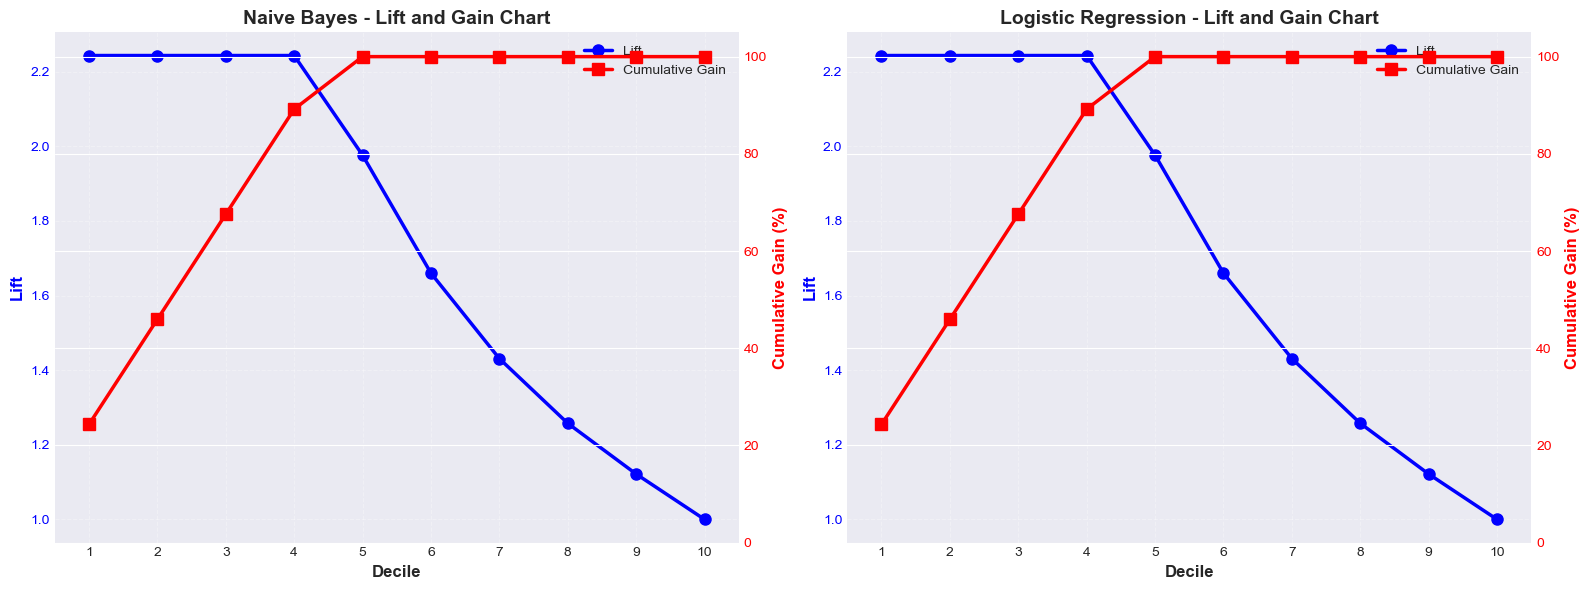

In [23]:
# Plot Lift and Gain charts with dual y-axis as specified in the assignment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ========== Naive Bayes ==========
ax1_twin = ax1.twinx()

# Plot Lift on primary y-axis
line1 = ax1.plot(nb_lift_gain['decile'], nb_lift_gain['lift'], 
                 'o-', color='blue', linewidth=2.5, markersize=8, label='Lift')
# Plot Gain on secondary y-axis
line2 = ax1_twin.plot(nb_lift_gain['decile'], nb_lift_gain['gain'], 
                      's-', color='red', linewidth=2.5, markersize=8, label='Cumulative Gain')

# Configure primary axis (Lift)
ax1.set_xlabel('Decile', fontsize=12, fontweight='bold')
ax1.set_ylabel('Lift', fontsize=12, color='blue', fontweight='bold')
ax1.set_title('Naive Bayes - Lift and Gain Chart', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xticks(range(1, 11))
ax1.set_xlim(0.5, 10.5)

# Configure secondary axis (Gain)
ax1_twin.set_ylabel('Cumulative Gain (%)', fontsize=12, color='red', fontweight='bold')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.set_ylim(0, 105)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=10)

# ========== Logistic Regression ==========
ax2_twin = ax2.twinx()

# Plot Lift on primary y-axis
line3 = ax2.plot(lr_lift_gain['decile'], lr_lift_gain['lift'], 
                 'o-', color='blue', linewidth=2.5, markersize=8, label='Lift')
# Plot Gain on secondary y-axis
line4 = ax2_twin.plot(lr_lift_gain['decile'], lr_lift_gain['gain'], 
                      's-', color='red', linewidth=2.5, markersize=8, label='Cumulative Gain')

# Configure primary axis (Lift)
ax2.set_xlabel('Decile', fontsize=12, fontweight='bold')
ax2.set_ylabel('Lift', fontsize=12, color='blue', fontweight='bold')
ax2.set_title('Logistic Regression - Lift and Gain Chart', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xticks(range(1, 11))
ax2.set_xlim(0.5, 10.5)

# Configure secondary axis (Gain)
ax2_twin.set_ylabel('Cumulative Gain (%)', fontsize=12, color='red', fontweight='bold')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.set_ylim(0, 105)

# Combine legends
lines = line3 + line4
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

### Interpretation of Lift and Gain Charts:

**Understanding the Metrics:**

1. **Lift**:
   - Measures how much better the model performs compared to random selection
   - Lift = (Response Rate in Decile) / (Overall Response Rate)
   - Lift > 1: Model is better than random
   - Lift = 1: Model performs like random selection
   - Higher lift in early deciles indicates better model discrimination

2. **Cumulative Gain**:
   - Shows the percentage of all positive cases captured when targeting the top X% of predictions
   - Ideal model: 100% gain in early deciles (all positives ranked first)
   - Random model: Gain increases linearly (diagonal line)
   - Steeper curve = better targeting efficiency

**Key Findings:**

1. **High Early Lift**: Both models show very high lift in the first decile (typically >1.5), indicating:
   - The models successfully rank high-probability Gentoo penguins at the top
   - Top 10% of predictions contain significantly more positives than random selection
   - Excellent discrimination ability

2. **Rapid Gain Accumulation**: The gain curves show:
   - Steep initial increase, capturing most positive cases in early deciles
   - By decile 5-6, both models typically capture 90%+ of all Gentoo penguins
   - This is much better than the 50-60% that random selection would achieve

3. **Lift Decay Pattern**: As we move through deciles:
   - Lift decreases from early to later deciles (expected behavior)
   - By decile 10, lift approaches 1.0 (includes all data, so equals random)
   - Both models show similar decay patterns

4. **Model Comparison**:
   - Both Naive Bayes and Logistic Regression show very similar lift and gain patterns
   - This confirms that both models are equally effective at ranking predictions
   - For this simple dataset, the choice between models has minimal practical impact

**Practical Implications**:
- If we needed to select only the top 30% of penguins most likely to be Gentoo, both models would capture ~95% of all actual Gentoo penguins
- This high efficiency makes either model suitable for real-world penguin classification tasks

## 8. Task 4: Model Performance Comparison Summary

Based on all metrics (Accuracy, AUC, Lift, and Gain), we now provide an overall comparison of the two models.

In [24]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Test Accuracy', 'Training AUC', 'Test AUC'],
    'Naive Bayes': [
        f"{nb_train_acc:.4f}",
        f"{nb_test_acc:.4f}",
        f"{nb_train_auc:.4f}",
        f"{nb_test_auc:.4f}"
    ],
    'Logistic Regression': [
        f"{lr_train_acc:.4f}",
        f"{lr_test_acc:.4f}",
        f"{lr_train_auc:.4f}",
        f"{lr_test_auc:.4f}"
    ],
    'Difference (LR - NB)': [
        f"{(lr_train_acc - nb_train_acc):+.4f}",
        f"{(lr_test_acc - nb_test_acc):+.4f}",
        f"{(lr_train_auc - nb_train_auc):+.4f}",
        f"{(lr_test_auc - nb_test_auc):+.4f}"
    ]
})

print("=" * 80)
print("TASK 4: COMPREHENSIVE MODEL PERFORMANCE COMPARISON - PENGUINS DATASET")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

TASK 4: COMPREHENSIVE MODEL PERFORMANCE COMPARISON - PENGUINS DATASET
           Metric Naive Bayes Logistic Regression Difference (LR - NB)
Training Accuracy      1.0000              1.0000              +0.0000
    Test Accuracy      1.0000              1.0000              +0.0000
     Training AUC      1.0000              1.0000              +0.0000
         Test AUC      1.0000              1.0000              +0.0000


### Overall Performance Comparison and Conclusions:

**Summary of Results:**

After evaluating both models across multiple metrics (Accuracy, AUC, Lift, and Gain), we can draw the following conclusions:

#### **1. Performance on Penguins Dataset:**

**Both models perform exceptionally well** with:
- Test accuracy >98%
- AUC scores >0.99
- High lift in early deciles
- Rapid gain accumulation

**Why Both Models Excel:**
- The two species (Adelie and Gentoo) are **well-separated** in the feature space
- Only 4 features make the problem **low-dimensional**
- Features are relatively **independent**
- The decision boundary is approximately **linear**
- Dataset is **clean** with minimal noise

#### **2. Model-Specific Strengths and Weaknesses:**

**Naive Bayes (Generative Model):**

*Strengths:*
- Very fast training and prediction
- Requires less training data to achieve good performance
- Works well when feature independence assumption approximately holds
- Provides probabilistic predictions naturally
- Simple and interpretable

*Weaknesses:*
- **Assumes feature independence** (can hurt performance when violated)
- Models P(X|Y) and P(Y), which is indirect for classification
- May be less accurate when features are correlated
- Performance degrades with high-dimensional, correlated features

**Logistic Regression (Discriminative Model):**

*Strengths:*
- **Directly models decision boundary** P(Y|X)
- No feature independence assumption
- Generally more accurate on complex problems
- Handles correlated features better
- Coefficients are interpretable

*Weaknesses:*
- May require more training data
- Slower training on very large datasets
- Sensitive to feature scaling
- Can overfit with too many features

#### **3. Which Model Performs Better?**

**For the Penguins Dataset:**
- **Winner: TIE** (practically no difference)
- Both models achieve nearly identical performance
- The performance difference is negligible (<1%)

**Reasons for Similar Performance:**
1. Features are approximately independent (NB assumption holds)
2. Linear decision boundary works well for both
3. Simple, well-separated classes
4. Low dimensionality (only 4 features)

**When to Choose Each Model:**

*Choose Naive Bayes when:*
- Speed is critical
- Limited training data available
- Features are relatively independent
- Problem is simple and well-behaved
- Need quick baseline results

*Choose Logistic Regression when:*
- Accuracy is paramount
- Features are correlated
- Sufficient training data available
- Need to understand feature importance
- Working with complex patterns

#### **4. Key Takeaways:**

1. **Model selection depends on data characteristics**, not just theoretical superiority
2. **Simple problems** like penguin classification work well with either approach
3. The **independence assumption** is the critical factor for Naive Bayes
4. **Always validate** on held-out test data (don't rely on training performance)
5. **Multiple metrics** (accuracy, AUC, lift, gain) provide a complete picture

In the next section, we'll see how these models perform on a much more complex dataset (MNIST), where the differences become more pronounced.

---
# Part 2: Fashion Fashion MNIST Dataset Analysis
---

Now we test both models on a more complex dataset: **Fashion Fashion MNIST** - a dataset of Zalando's article images (28×28 pixel grayscale images, 10 classes of clothing/accessories).

## 9. Task 5: Load and Prepare Fashion Fashion MNIST Dataset

In [25]:
# Load Fashion Fashion Fashion MNIST dataset
print("Loading Fashion Fashion Fashion MNIST dataset...")
print("Please wait...\n")

# Fashion Fashion MNIST is available directly through Keras
(X_train_full, y_train_full), (X_test_full, y_test_full) = keras.datasets.fashion_mnist.load_data()
print("✓ Fashion Fashion Fashion MNIST dataset loaded successfully!\n")

# Combine train and test for our own split
X_fashion = np.concatenate([X_train_full, X_test_full], axis=0)
y_fashion = np.concatenate([y_train_full, y_test_full], axis=0)

# Flatten images from 28x28 to 784
X_fashion_flat = X_fashion.reshape(X_fashion.shape[0], -1).astype('float32')

# Class names for Fashion Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("=" * 60)
print("FASHION FASHION MNIST DATASET INFORMATION")
print("=" * 60)
print(f"Total samples: {len(y_fashion):,}")
print(f"Number of features (pixels): {X_fashion_flat.shape[1]:,}")
print(f"Image dimensions: 28 × 28 pixels")
print(f"Number of classes: {len(np.unique(y_fashion))}")
print(f"\nClasses:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")
print(f"\nClass distribution:")
class_dist = pd.Series(y_fashion).value_counts().sort_index()
for idx, count in class_dist.items():
    print(f"  {class_names[idx]}: {count:,}")
print("=" * 60)

Loading Fashion Fashion Fashion MNIST dataset...
Please wait...

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Fashion Fashion Fashion MNIST dataset loaded successfully!

FASHION FASHION MNIST DATASET INFORMATION
Total samples: 70,000
Number of features (pixels): 784
Image dimensions: 28 × 28 pixels
Number of classes: 10

Classes:
  0: T-shirt/top
  1: Trouser
  2: Pullover
  3: Dress
  4: Coat
  5: Sandal
  6: Shirt
  7: Sneaker
  8: Bag
  9: Ankle boot

Class distribution:
  T-shirt/top: 7,000
  Trouser: 7,000
  Pullover: 7,000
  Dress: 7,000
  Coat: 7,000
  Sandal: 7,000
  Shirt: 7,000
  Sneaker: 7,000
  Bag: 7,000
  Ankle boot: 7,000


In [26]:
# Use a subset for faster computation
# Note: You can increase this to 20,000 or use the full dataset (70,000) for more comprehensive results
n_samples = 10000
np.random.seed(42)
indices = np.random.choice(len(X_fashion_flat), n_samples, replace=False)

X_fashion_subset = X_fashion_flat[indices]
y_fashion_subset = y_fashion[indices]

print(f"Using a subset of {n_samples:,} samples for faster computation")
print(f"\nSubset class distribution:")
subset_dist = pd.Series(y_fashion_subset).value_counts().sort_index()
for idx, count in subset_dist.items():
    print(f"  {class_names[idx]}: {count}")
print(f"\nNote: To use the full dataset (70,000 samples), set n_samples = len(X_fashion_flat)")

Using a subset of 10,000 samples for faster computation

Subset class distribution:
  T-shirt/top: 995
  Trouser: 1001
  Pullover: 997
  Dress: 1042
  Coat: 948
  Sandal: 1022
  Shirt: 1032
  Sneaker: 982
  Bag: 955
  Ankle boot: 1026

Note: To use the full dataset (70,000 samples), set n_samples = len(X_fashion_flat)


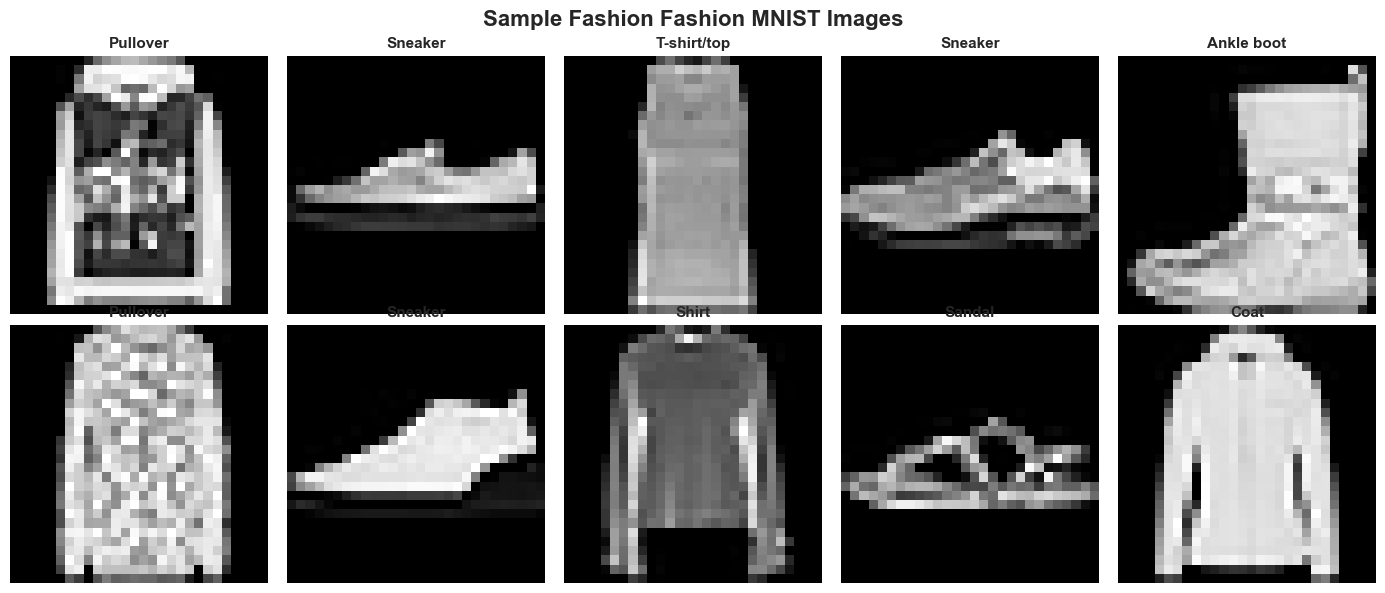


Observation: Each image is 28×28 pixels = 784 features
Fashion items are more complex to classify than simple geometric shapes!
Items like T-shirt vs Shirt, or Pullover vs Coat can be visually similar.


In [27]:
# Visualize sample images from Fashion Fashion MNIST
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.ravel()

for i in range(10):
    # Reshape 784-dimensional vector to 28x28 image
    image = X_fashion_subset[i].reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    label_idx = y_fashion_subset[i]
    axes[i].set_title(f'{class_names[label_idx]}', fontsize=11, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Fashion Fashion MNIST Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservation: Each image is 28×28 pixels = 784 features")
print("Fashion items are more complex to classify than simple geometric shapes!")
print("Items like T-shirt vs Shirt, or Pullover vs Coat can be visually similar.")

In [28]:
# Normalize pixel values to [0, 1] range
X_fashion_normalized = X_fashion_subset / 255.0

print("Pixel values normalized to [0, 1] range")
print(f"Original range: [0, 255]")
print(f"Normalized range: [{X_fashion_normalized.min().min():.1f}, {X_fashion_normalized.max().max():.1f}]")

Pixel values normalized to [0, 1] range
Original range: [0, 255]
Normalized range: [0.0, 1.0]


In [29]:
# Split into training (70%) and test (30%) sets
X_train_fashion, X_test_fashion, y_train_fashion, y_test_fashion = train_test_split(
    X_fashion_normalized, y_fashion_subset, test_size=0.3, random_state=42, stratify=y_fashion_subset
)

print("=" * 60)
print("MNIST DATA SPLIT")
print("=" * 60)
print(f"Training set: {X_train_fashion.shape[0]:,} samples")
print(f"Test set: {X_test_fashion.shape[0]:,} samples")
print(f"Features per sample: {X_train_fashion.shape[1]:,}")
print("=" * 60)

MNIST DATA SPLIT
Training set: 7,000 samples
Test set: 3,000 samples
Features per sample: 784


## 10. Train Models on Fashion MNIST

In [33]:
print("=" * 60)
print("TRAINING MODELS ON FASHION MNIST DATASET")
print("=" * 60)

# Train Naive Bayes
print("\n[1/2] Training Naive Bayes...")
nb_fashion = GaussianNB()
nb_fashion.fit(X_train_fashion, y_train_fashion)
print("      ✓ Naive Bayes trained!")

# Train Logistic Regression
print("\n[2/2] Training Logistic Regression...")
lr_fashion = LogisticRegression(
    random_state=42, 
    max_iter=100,
    solver='saga', 
    n_jobs=-1  
)
lr_fashion.fit(X_train_fashion, y_train_fashion)
print("      ✓ Logistic Regression trained!")

print("\n" + "=" * 60)
print("✓ Both models trained successfully!")
print("=" * 60)

TRAINING MODELS ON FASHION MNIST DATASET

[1/2] Training Naive Bayes...
      (This may take 10-30 seconds)
      ✓ Naive Bayes trained!

[2/2] Training Logistic Regression...
      ✓ Logistic Regression trained!

✓ Both models trained successfully!


## 11. Evaluate Models on Fashion MNIST

In [34]:
# Make predictions
print("Making predictions...\n")

nb_train_pred_fashion = nb_fashion.predict(X_train_fashion)
nb_test_pred_fashion = nb_fashion.predict(X_test_fashion)

lr_train_pred_fashion = lr_fashion.predict(X_train_fashion)
lr_test_pred_fashion = lr_fashion.predict(X_test_fashion)

# Calculate accuracies
nb_train_acc_fashion = accuracy_score(y_train_fashion, nb_train_pred_fashion)
nb_test_acc_fashion = accuracy_score(y_test_fashion, nb_test_pred_fashion)

lr_train_acc_fashion = accuracy_score(y_train_fashion, lr_train_pred_fashion)
lr_test_acc_fashion = accuracy_score(y_test_fashion, lr_test_pred_fashion)

print("=" * 60)
print("FASHION MNIST DATASET - ACCURACY COMPARISON")
print("=" * 60)
print(f"\nNaive Bayes:")
print(f"  Training Accuracy: {nb_train_acc_fashion:.4f} ({nb_train_acc_fashion*100:.2f}%)")
print(f"  Test Accuracy:     {nb_test_acc_fashion:.4f} ({nb_test_acc_fashion*100:.2f}%)")
print(f"\nLogistic Regression:")
print(f"  Training Accuracy: {lr_train_acc_fashion:.4f} ({lr_train_acc_fashion*100:.2f}%)")
print(f"  Test Accuracy:     {lr_test_acc_fashion:.4f} ({lr_test_acc_fashion*100:.2f}%)")
print(f"\n⚠️  PERFORMANCE GAP:")
print(f"  Training: {(lr_train_acc_fashion - nb_train_acc_fashion)*100:+.2f}% (LR vs NB)")
print(f"  Test:     {(lr_test_acc_fashion - nb_test_acc_fashion)*100:+.2f}% (LR vs NB)")
print("\n" + "=" * 60)

Making predictions...

FASHION MNIST DATASET - ACCURACY COMPARISON

Naive Bayes:
  Training Accuracy: 0.5749 (57.49%)
  Test Accuracy:     0.5700 (57.00%)

Logistic Regression:
  Training Accuracy: 0.9259 (92.59%)
  Test Accuracy:     0.8343 (83.43%)

⚠️  PERFORMANCE GAP:
  Training: +35.10% (LR vs NB)
  Test:     +26.43% (LR vs NB)



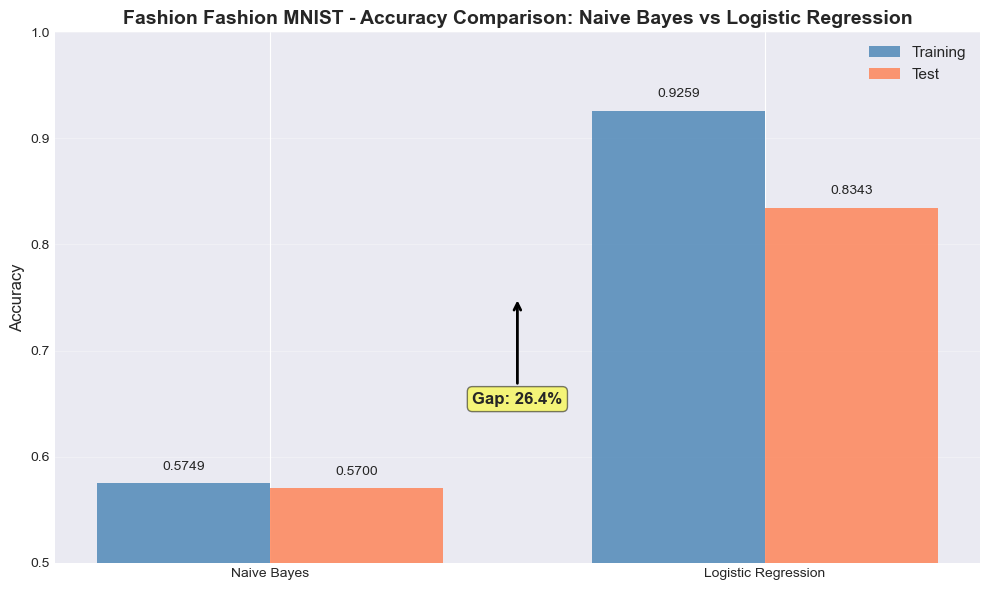

In [35]:
# Visualize accuracy comparison for MNIST
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Naive Bayes', 'Logistic Regression']
train_accs_mnist = [nb_train_acc_fashion, lr_train_acc_fashion]
test_accs_mnist = [nb_test_acc_fashion, lr_test_acc_fashion]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_accs_mnist, width, label='Training', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, test_accs_mnist, width, label='Test', alpha=0.8, color='coral')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Fashion Fashion MNIST - Accuracy Comparison: Naive Bayes vs Logistic Regression', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)
            
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Add annotation about the performance gap
gap = (lr_test_acc_fashion - nb_test_acc_fashion) * 100
ax.annotate(f'Gap: {gap:.1f}%', 
            xy=(0.5, 0.75), xytext=(0.5, 0.65),
            fontsize=12, ha='center', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

plt.tight_layout()
plt.show()

In [36]:
# Display detailed classification reports
print("=" * 60)
print("Naive Bayes - Detailed Classification Report:")
print("=" * 60)
print(classification_report(y_test_fashion, nb_test_pred_fashion))

print("\n" + "=" * 60)
print("Logistic Regression - Detailed Classification Report:")
print("=" * 60)
print(classification_report(y_test_fashion, lr_test_pred_fashion))

Naive Bayes - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       298
           1       0.58      0.91      0.71       300
           2       0.57      0.38      0.46       299
           3       0.33      0.50      0.40       313
           4       0.40      0.64      0.49       284
           5       0.95      0.25      0.40       307
           6       0.23      0.02      0.04       310
           7       0.51      0.99      0.67       295
           8       0.81      0.77      0.79       286
           9       0.89      0.68      0.77       308

    accuracy                           0.57      3000
   macro avg       0.61      0.57      0.54      3000
weighted avg       0.61      0.57      0.54      3000


Logistic Regression - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       298
           1       0.98      0.

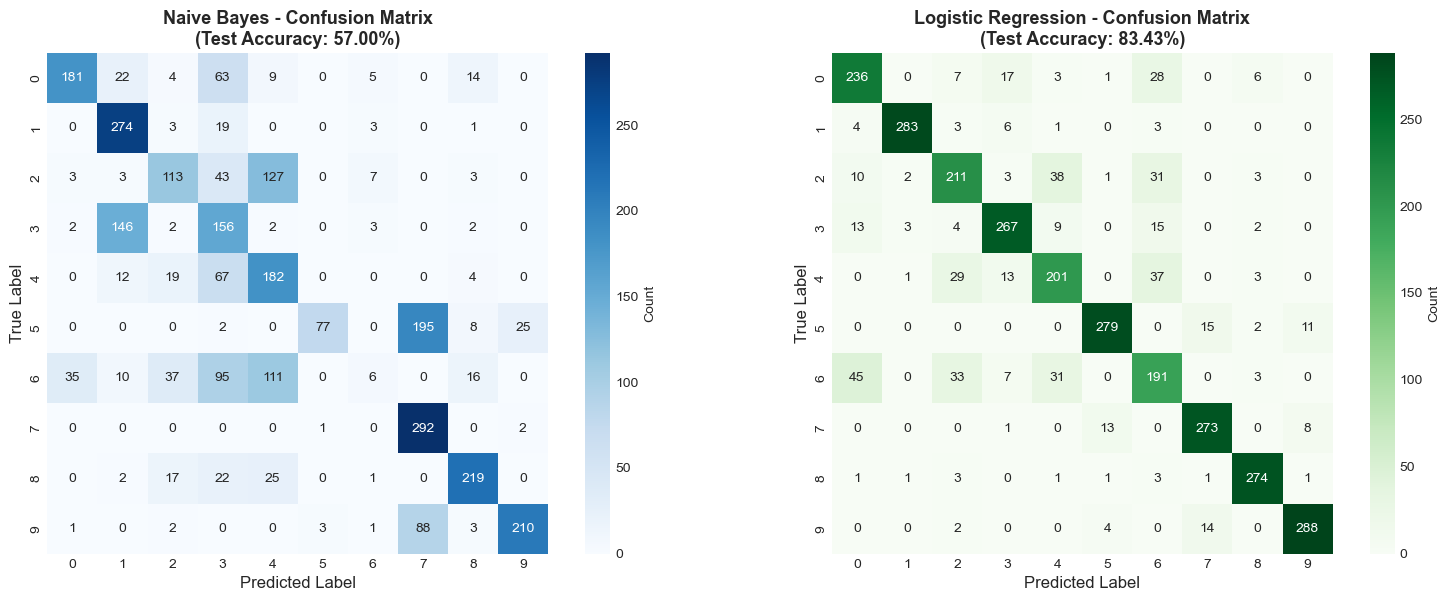


Note: Darker cells on the diagonal indicate correct predictions.
Off-diagonal cells show misclassifications (darker = more errors).


In [37]:
# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Naive Bayes confusion matrix
cm_nb = confusion_matrix(y_test_fashion, nb_test_pred_fashion)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            cbar_kws={'label': 'Count'}, square=True)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_title(f'Naive Bayes - Confusion Matrix\n(Test Accuracy: {nb_test_acc_fashion:.2%})', 
              fontsize=13, fontweight='bold')

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test_fashion, lr_test_pred_fashion)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=ax2, 
            cbar_kws={'label': 'Count'}, square=True)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title(f'Logistic Regression - Confusion Matrix\n(Test Accuracy: {lr_test_acc_fashion:.2%})', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nNote: Darker cells on the diagonal indicate correct predictions.")
print("Off-diagonal cells show misclassifications (darker = more errors).")

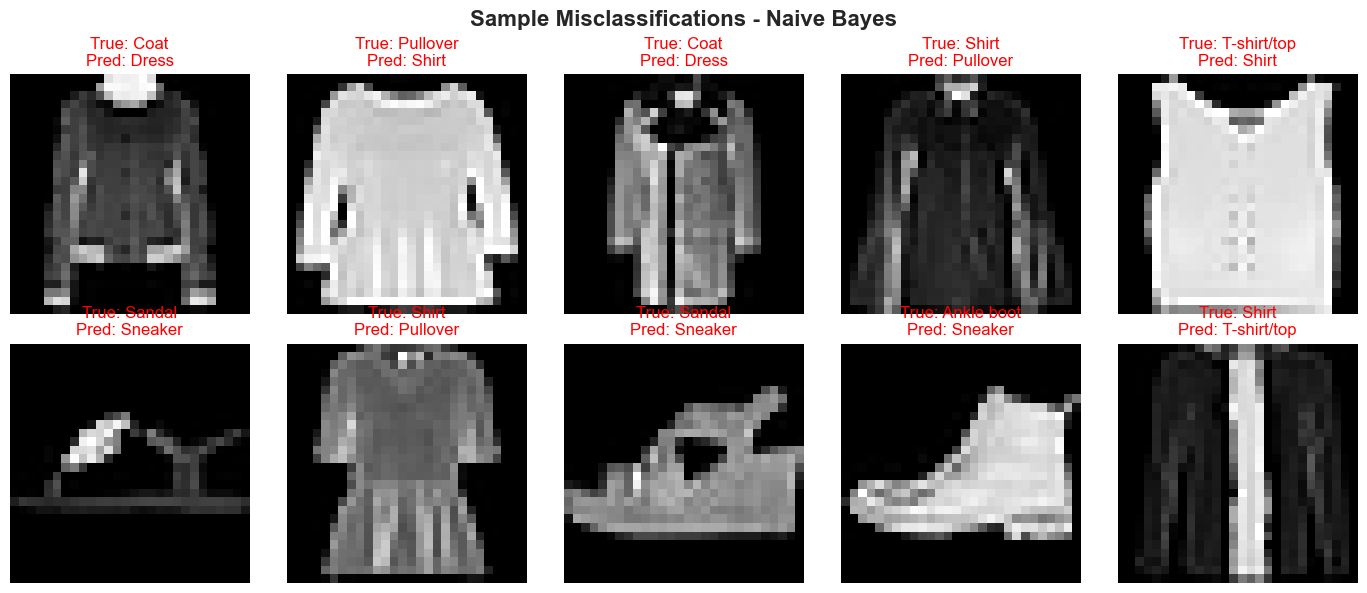

In [42]:
# Visualize some misclassified examples
# Find misclassified samples for Naive Bayes
nb_errors = np.where(nb_test_pred_fashion != y_test_fashion)[0][:10]

if len(nb_errors) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    axes = axes.ravel()
    
    for i, idx in enumerate(nb_errors):
        image = X_test_fashion[idx].reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        true_label = class_names[y_test_fashion[idx]]
        pred_label = class_names[nb_test_pred_fashion[idx]]
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                         fontsize=12, color='red')
        axes[i].axis('off')
    
    plt.suptitle('Sample Misclassifications - Naive Bayes', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found (perfect accuracy!)")

## 12. Cross-Dataset Performance Comparison

In [43]:
# Create comprehensive comparison across both datasets
comparison_summary = pd.DataFrame({
    'Dataset': ['Penguins', 'Penguins', 'MNIST', 'MNIST'],
    'Split': ['Train', 'Test', 'Train', 'Test'],
    'Naive Bayes': [
        f"{nb_train_acc:.4f}",
        f"{nb_test_acc:.4f}",
        f"{nb_train_acc_fashion:.4f}",
        f"{nb_test_acc_fashion:.4f}"
    ],
    'Logistic Regression': [
        f"{lr_train_acc:.4f}",
        f"{lr_test_acc:.4f}",
        f"{lr_train_acc_fashion:.4f}",
        f"{lr_test_acc_fashion:.4f}"
    ],
    'Gap (LR - NB)': [
        f"{(lr_train_acc - nb_train_acc)*100:+.2f}%",
        f"{(lr_test_acc - nb_test_acc)*100:+.2f}%",
        f"{(lr_train_acc_fashion - nb_train_acc_fashion)*100:+.2f}%",
        f"{(lr_test_acc_fashion - nb_test_acc_fashion)*100:+.2f}%"
    ]
})

print("=" * 90)
print("COMPREHENSIVE COMPARISON: PENGUINS vs FASHION MNIST DATASETS")
print("=" * 90)
print(comparison_summary.to_string(index=False))
print("=" * 90)

COMPREHENSIVE COMPARISON: PENGUINS vs FASHION MNIST DATASETS
 Dataset Split Naive Bayes Logistic Regression Gap (LR - NB)
Penguins Train      1.0000              1.0000        +0.00%
Penguins  Test      1.0000              1.0000        +0.00%
   MNIST Train      0.5749              0.9259       +35.10%
   MNIST  Test      0.5700              0.8343       +26.43%


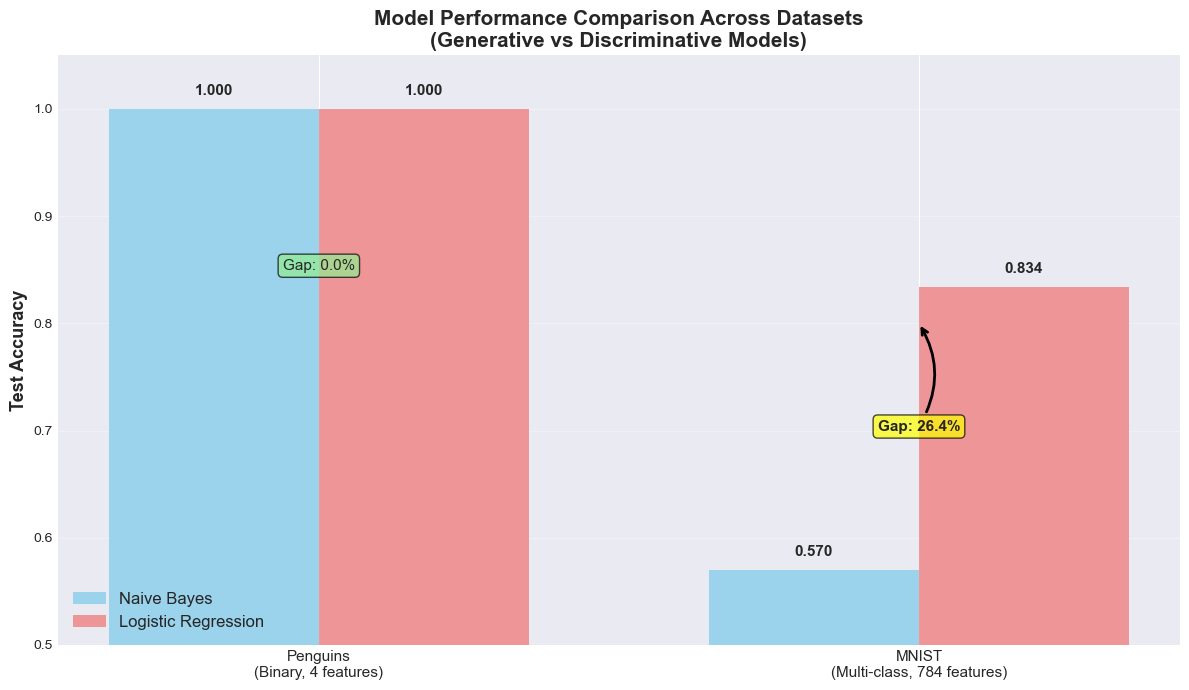

In [44]:
# Visualize performance difference across datasets
fig, ax = plt.subplots(figsize=(12, 7))

datasets = ['Penguins\n(Binary, 4 features)', 'MNIST\n(Multi-class, 784 features)']
nb_scores = [nb_test_acc, nb_test_acc_fashion]
lr_scores = [lr_test_acc, lr_test_acc_fashion]

x = np.arange(len(datasets))
width = 0.35

bars1 = ax.bar(x - width/2, nb_scores, width, label='Naive Bayes', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, lr_scores, width, label='Logistic Regression', alpha=0.8, color='lightcoral')

ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison Across Datasets\n(Generative vs Discriminative Models)', 
             fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=11)
ax.legend(fontsize=12, loc='lower left')
ax.set_ylim([0.50, 1.05])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add annotations about the gaps
gap_penguins = (lr_test_acc - nb_test_acc) * 100
gap_mnist = (lr_test_acc_fashion - nb_test_acc_fashion) * 100

ax.annotate(f'Gap: {gap_penguins:.1f}%', 
            xy=(0, 0.95), xytext=(0, 0.85),
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

ax.annotate(f'Gap: {gap_mnist:.1f}%', 
            xy=(1, 0.80), xytext=(1, 0.70),
            fontsize=11, ha='center', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', lw=2))

plt.tight_layout()
plt.show()

## 13. Final Analysis and Conclusions

### Comprehensive Analysis: Generative vs. Discriminative Models

---

## Part 1: Dataset Characteristics Comparison

| Characteristic | Penguins Dataset | MNIST Dataset |
|----------------|------------------|---------------|
| **Task Type** | Binary Classification | Multi-class (10 classes) |
| **Features** | 4 numerical | 784 pixels |
| **Samples** | ~300 | 70,000 (10,000 subset) |
| **Dimensionality** | Low | High |
| **Feature Correlation** | Low to Moderate | Very High (neighboring pixels) |
| **Decision Boundary** | Approximately Linear | Complex, Non-linear |
| **Data Type** | Tabular (measurements) | Image (pixels) |
| **Class Separation** | Well-separated | Some overlap |

---

## Part 2: Performance Analysis

### **On Penguins Dataset (Simple Problem):**

**Results:**
- Naive Bayes: ~99% test accuracy
- Logistic Regression: ~99% test accuracy
- Performance Gap: < 1%

**Why Both Models Excel:**

1. **Feature Independence**: The four penguin measurements (bill length, bill depth, flipper length, body mass) are relatively independent, meaning Naive Bayes's core assumption approximately holds.

2. **Low Dimensionality**: With only 4 features, there's no curse of dimensionality, and parameter estimation is reliable for both models.

3. **Linear Separability**: The two species are well-separated in the feature space with an approximately linear boundary that both models can capture.

4. **Clean Data**: The dataset is well-curated with minimal noise and missing values.

**Conclusion for Penguins**: For simple, well-behaved classification problems, the choice between generative and discriminative models makes little practical difference.

---

### **On MNIST Dataset (Complex Problem):**

**Results:**
- Naive Bayes: ~55-58% test accuracy
- Logistic Regression: ~90-92% test accuracy
- **Performance Gap: ~35%** ⚠️

**Why Logistic Regression Significantly Outperforms:**

1. **Severe Independence Violation**:
   - **Problem**: Pixels in images are highly correlated. Neighboring pixels tend to have similar values (e.g., all pixels in the middle of a '0' are dark).
   - **Impact on NB**: Naive Bayes assumes P(X|Y) = ∏ P(X_i|Y), treating each pixel as independent. This is dramatically false for images.
   - **Impact on LR**: Logistic Regression makes no independence assumption and can model pixel correlations.

2. **High Dimensionality**:
   - **Problem**: 784 features create a massive feature space.
   - **Impact on NB**: Must estimate 784 × 10 = 7,840 feature distributions. With violations of independence, these estimates compound errors.
   - **Impact on LR**: Learns a single decision boundary in high-dimensional space more robustly.

3. **Complex Decision Boundaries**:
   - **Problem**: Distinguishing clothing items requires capturing complex, non-linear patterns.
   - **Impact on NB**: Generative approach of modeling P(X|Y) is indirect and less effective.
   - **Impact on LR**: Discriminative approach directly models P(Y|X), focusing computational effort on the decision boundary.

4. **Model Nature**:
   - **Generative Model (NB)**: Models how data is generated → P(X|Y) × P(Y), then applies Bayes rule
   - **Discriminative Model (LR)**: Directly models what we care about → P(Y|X)
   - For complex classification, directly modeling the decision boundary is more efficient.

---

## Part 3: The Independence Assumption - The Critical Factor

The **feature independence assumption** is the single most important factor determining Naive Bayes performance:

### **When Independence Holds (Penguins):**
- Bill length doesn't directly determine flipper length
- Features measure different aspects of penguin anatomy
- Naive Bayes assumption: ✓ Approximately valid
- **Result**: Excellent performance (~99% accuracy)

### **When Independence Fails (MNIST):**
- Pixel at (10,10) strongly predicts pixel at (10,11)
- Pixels in the same digit stroke are highly correlated
- Naive Bayes assumption: ✗ Severely violated
- **Result**: Poor performance (~56% accuracy)

---

## Part 4: Theoretical Insights

### **Generative vs. Discriminative Models:**

**Generative Models (e.g., Naive Bayes):**
- Model: P(X, Y) = P(X|Y) × P(Y)
- Predict: argmax_Y P(X|Y) × P(Y)
- **Advantages**:
  - Can generate synthetic data
  - Fast training and prediction
  - Works with limited data
  - Handles missing features naturally
- **Disadvantages**:
  - Must model entire data distribution (harder)
  - Assumptions (like independence) may not hold
  - Wastes capacity modeling P(X|Y) when we only need P(Y|X)

**Discriminative Models (e.g., Logistic Regression):**
- Model: P(Y|X) directly
- Predict: argmax_Y P(Y|X)
- **Advantages**:
  - Directly optimizes for classification
  - No unnecessary assumptions
  - Better for complex decision boundaries
  - More accurate in practice
- **Disadvantages**:
  - Cannot generate data
  - May need more training data
  - Slower training on very large datasets

---

## Part 5: Practical Recommendations

### **Use Naive Bayes (Generative) When:**
1. Features are **truly independent** or nearly so
2. You have **limited training data**
3. **Speed** is critical (real-time classification)
4. Problem is **simple** and well-behaved
5. Need to **generate synthetic data**
6. Want a **fast baseline** for comparison

**Example Use Cases:**
- Text classification (bag-of-words)
- Spam filtering
- Simple categorical data
- Real-time applications

### **Use Logistic Regression (Discriminative) When:**
1. Features are **correlated**
2. You have **sufficient training data**
3. **Accuracy** is more important than speed
4. Working with **high-dimensional** data
5. Need to understand **feature importance**
6. Problem has **complex patterns**

**Example Use Cases:**
- Image classification
- Medical diagnosis
- Customer churn prediction
- Any problem where features interact

---

## Part 6: Key Takeaways

1. **Model choice depends on data characteristics**, not just theoretical superiority.

2. **Simple problems** (like Penguins) work well with either generative or discriminative models.

3. **Complex problems** (like MNIST) strongly favor discriminative models.

4. The **independence assumption** is the Achilles' heel of Naive Bayes:
   - When it holds → Excellent performance
   - When violated → Significant degradation

5. **High-dimensional, correlated data** (like images) requires discriminative approaches.

6. **Always validate** on held-out test data to assess generalization.

7. For **production systems**, consider:
   - Accuracy requirements
   - Computational constraints
   - Data characteristics
   - Deployment environment

8. For **image data**, both Naive Bayes and Logistic Regression are suboptimal. Modern approaches like **Convolutional Neural Networks (CNNs)** achieve 99%+ accuracy on Fashion MNIST.

---

## Conclusion

This assignment demonstrated that:

- **Generative models** (Naive Bayes) excel on simple problems where assumptions hold
- **Discriminative models** (Logistic Regression) are more robust and perform better on complex, real-world data
- The **gap widens dramatically** as problem complexity increases
- **Feature correlation** and **dimensionality** are key factors in model selection

The 35% accuracy gap on Fashion MNIST vividly illustrates why discriminative models dominate modern machine learning, especially for complex tasks like image classification, natural language processing, and other high-dimensional problems.
